## CBOW Model

### Set up data

In [1]:
import collections, re, os 
import pandas as pd, numpy as np

from argparse import Namespace

In [2]:
if not os.path.exists('data/ag_news'):
  os.makedirs('data/ag_news')
  
args = Namespace(
    raw_dataset_csv="data/ag_news/news.csv",
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="data/ag_news/news_with_splits.csv",
    seed=1337
)

In [3]:
#Read data
news = pd.read_pickle('results/inflacion.pkl')[['text', 'label']]
news = news[news.label != 'neutro']
#news['label'] = news['label'].replace({'negativo':0,'positivo':1})
news = news.rename(columns={'text':'title','label':'category'})

# Filtering sentences with more than 5 words
news['word_count'] = news['title'].apply(lambda x: len(x.split()))
news = news[news['word_count'] > 5]
# Dropping the word_count column if not needed
news = news.drop(columns=['word_count'])
#news = news.drop_duplicates()
news.to_csv(args.raw_dataset_csv,index=False)

In [4]:
# Read raw data
news = pd.read_csv(args.raw_dataset_csv, header=0)
news.sample(3)

,title,category
9869,gobierno federal modernizando hidroelectricas ...,positivo
4609,semana pasada pekin pidio provincias relajar e...,negativo
5152,enero septiembre mexico capto mil millones dol...,negativo


In [5]:
# Splitting train by category
# Create dict
by_category = collections.defaultdict(list)
for _, row in news.iterrows():
    by_category[row.category].append(row.to_dict())

In [6]:
# Create split data
final_list = []
np.random.seed(args.seed)
for _, item_list in sorted(by_category.items()):
    np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_proportion*n)
    n_val = int(args.val_proportion*n)
    n_test = int(args.test_proportion*n)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  
    
    # Add to final list
    final_list.extend(item_list)

In [7]:
# Write split data to file
final_news = pd.DataFrame(final_list)

In [8]:
final_news.split.value_counts()

split
train    7144
test     1533
val      1530
Name: count, dtype: int64

In [9]:
# Preprocess the reviews
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
final_news.title = final_news.title.apply(preprocess_text)

In [10]:
final_news.head()

,title,category,split
0,pandemia covid llevo crisis economica sanitari...,negativo,train
1,arturo herrera hizo recuento actual crisis dij...,negativo,train
2,detallo segun informacion frente nuevo leon ww...,negativo,train
3,inflacion mexico encuentra boton freno pese es...,negativo,train
4,es necesario prevenir mitigar efectos cambio c...,negativo,train


In [11]:
# Write munged data to CSV
final_news.to_csv(args.output_munged_csv, index=False)

In [12]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from tqdm import tqdm_notebook

## Vocabulary

In [13]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

## The verctorizer function

In [14]:
class NewsVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, title_vocab, category_vocab):
        self.title_vocab = title_vocab
        self.category_vocab = category_vocab

    def vectorize(self, title, vector_length=-1):
        """
        Args:
            title (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vetorized title (numpy.array)
        """
        indices = [self.title_vocab.begin_seq_index]
        indices.extend(self.title_vocab.lookup_token(token) 
                       for token in title.split(" "))
        indices.append(self.title_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.title_vocab.mask_index

        return out_vector

    @classmethod
    def from_dataframe(cls, news_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            news_df (pandas.DataFrame): the target dataset
            cutoff (int): frequency threshold for including in Vocabulary 
        Returns:
            an instance of the NewsVectorizer
        """
        category_vocab = Vocabulary()        
        for category in sorted(set(news_df.category)):
            category_vocab.add_token(category)

        word_counts = Counter()
        for title in news_df.title:
            for token in title.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        title_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                title_vocab.add_token(word)
        
        return cls(title_vocab, category_vocab)

    @classmethod
    def from_serializable(cls, contents):
        title_vocab = \
            SequenceVocabulary.from_serializable(contents['title_vocab'])
        category_vocab =  \
            Vocabulary.from_serializable(contents['category_vocab'])

        return cls(title_vocab=title_vocab, category_vocab=category_vocab)

    def to_serializable(self):
        return {'title_vocab': self.title_vocab.to_serializable(),
                'category_vocab': self.category_vocab.to_serializable()}

## The dataset

In [15]:
class NewsDataset(Dataset):
    def __init__(self, news_df, vectorizer):
        """
        Args:
            news_df (pandas.DataFrame): the dataset
            vectorizer (NewsVectorizer): vectorizer instatiated from dataset
        """
        self.news_df = news_df
        self._vectorizer = vectorizer

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, news_df.title)) + 2
        

        self.train_df = self.news_df[self.news_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.news_df[self.news_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.news_df[self.news_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # Class weights
        class_counts = news_df.category.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, news_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        news_df = pd.read_csv(news_csv)
        train_news_df = news_df[news_df.split=='train']
        return cls(news_df, NewsVectorizer.from_dataframe(train_news_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, news_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        news_df = pd.read_csv(news_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(news_csv, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return NameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        title_vector = \
            self._vectorizer.vectorize(row.title, self._max_seq_length)

        category_index = \
            self._vectorizer.category_vocab.lookup_token(row.category)

        return {'x_data': title_vector,
                'y_target': category_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict


## The model

In [16]:
class NewsClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_channels, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            filter_width (int): width of the convolutional kernels
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        super(NewsClassifier, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
            
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=embedding_size, 
                   out_channels=num_channels, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3),
            nn.ReLU()
        )

        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(num_channels, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        # embed and permute so features are channels
        x_embedded = self.emb(x_in).permute(0, 2, 1)

        features = self.convnet(x_embedded)

        # average and remove the extra dimension
        remaining_size = features.size(dim=2)
        features = F.avg_pool1d(features, remaining_size).squeeze(dim=2)
        features = F.dropout(features, p=self._dropout_p)
        
        # mlp classifier
        intermediate_vector = F.relu(F.dropout(self.fc1(features), p=self._dropout_p))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector


## Training Routine
#### Helper functions

In [17]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e2,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [18]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
def load_glove_from_file(glove_filepath):
    """
    Load the GloVe embeddings 
    
    Args:
        glove_filepath (str): path to the glove embeddings file 
    Returns:
        word_to_index (dict), embeddings (numpy.ndarary)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, "r") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(glove_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

In [19]:
args = Namespace(
    # Data and Path hyper parameters
    news_csv="data/ag_news/news_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="data/ag_news",
    # Model hyper parameters
    glove_filepath='data/GloVe/glove.42B.300d.txt', 
    use_glove=False,
    embedding_size=300, 
    hidden_dim=100, 
    num_channels=100, 
    # Training hyper parameter
    seed=1337, 
    learning_rate=0.001, 
    dropout_p=0.6, 
    batch_size=32, 
    num_epochs=50, 
    early_stopping_criteria=10, 
    # Runtime option
    cuda=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
) 

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = True
    
args.device = torch.device("mps" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	data/ag_news/vectorizer.json
	data/ag_news/model.pth
Using CUDA: True


In [20]:
args.use_glove = True

In [21]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = NewsDataset.load_dataset_and_load_vectorizer(args.news_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = NewsDataset.load_dataset_and_make_vectorizer(args.news_csv)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.title_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

Using pre-trained embeddings


In [22]:
embeddings#.shape

array([[-0.11907164, -0.00123772,  0.03475952, ...,  0.10838436,
        -0.02188396, -0.09059642],
       [-0.03658002,  0.06027976, -0.01801901, ...,  0.11394492,
        -0.03662597, -0.09734905],
       [-0.07221913, -0.02466366, -0.03699218, ...,  0.02992471,
        -0.07259606, -0.04028996],
       ...,
       [-0.12786381,  0.01684663, -0.06325437, ...,  0.08102538,
         0.08740601, -0.04285508],
       [-0.11106642, -0.025025  , -0.12704852, ...,  0.01914428,
         0.11421919, -0.02601515],
       [ 0.56329   , -0.2405    ,  0.22467   , ..., -0.54394   ,
         0.31793   , -0.054541  ]])

In [23]:
classifier = NewsClassifier(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.title_vocab),
                            num_channels=args.num_channels,
                            hidden_dim=args.hidden_dim, 
                            num_classes=len(vectorizer.category_vocab), 
                            dropout_p=args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)
summary(classifier)

Layer (type:depth-idx)                   Param #
NewsClassifier                           --
├─Embedding: 1-1                         888,900
├─Sequential: 1-2                        --
│    └─Conv1d: 2-1                       90,100
│    └─ReLU: 2-2                         --
│    └─Conv1d: 2-3                       30,100
│    └─ReLU: 2-4                         --
│    └─Conv1d: 2-5                       30,100
│    └─ReLU: 2-6                         --
│    └─Conv1d: 2-7                       30,100
│    └─ReLU: 2-8                         --
├─Linear: 1-3                            10,100
├─Linear: 1-4                            202
Total params: 1,079,602
Trainable params: 1,079,602
Non-trainable params: 0

In [24]:
embeddings.shape

(2963, 300)

## Training loop

In [25]:
from tqdm.notebook import trange, tqdm
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), 
                       lr=args.learning_rate,
                       weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_data'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_data'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/50 [00:00<?, ?it/s]

split=train:   0%|          | 0/223 [00:00<?, ?it/s]

split=val:   0%|          | 0/47 [00:00<?, ?it/s]

In [26]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 0.6934280560371722;
Test Accuracy: 49.20212765957446


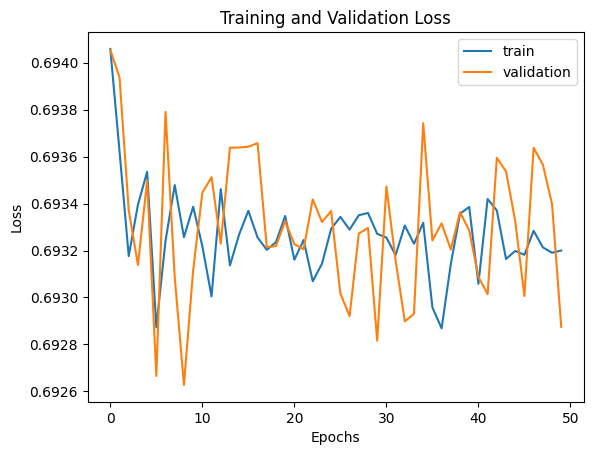

In [27]:
import matplotlib.pyplot as plt 
plt.plot(train_state['train_loss'], label='train')
plt.plot(train_state['val_loss'], label='validation')
plt.xlabel('Epochs')  # Assuming the x-axis represents epochs
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show();

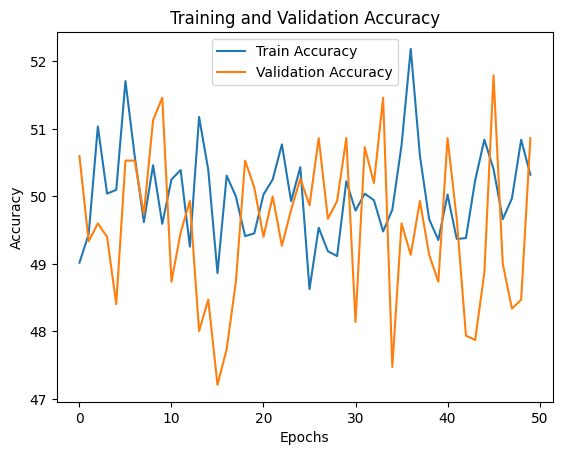

In [28]:
import matplotlib.pyplot as plt

# Ensure train_state is defined and contains 'train_acc' and 'val_acc'

plt.plot(train_state['train_acc'], label='Train Accuracy')
plt.plot(train_state['val_acc'], label='Validation Accuracy')

plt.xlabel('Epochs')  # Assuming the x-axis represents epochs
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


## Inferences

In [32]:
# Preprocess the reviews
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
def predict_category(title, classifier, vectorizer, max_length):
    """Predict a News category for a new title
    
    Args:
        title (str): a raw title string
        classifier (NewsClassifier): an instance of the trained classifier
        vectorizer (NewsVectorizer): the corresponding vectorizer
        max_length (int): the max sequence length
            Note: CNNs are sensitive to the input data tensor size. 
                  This ensures to keep it the same size as the training data
    """
    title = preprocess_text(title)
    vectorized_title = \
        torch.tensor(vectorizer.vectorize(title, vector_length=max_length))
    result = classifier(vectorized_title.unsqueeze(0), apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    predicted_category = vectorizer.category_vocab.lookup_index(indices.item())

    return {'category': predicted_category, 
            'probability': probability_values.item()}
def get_samples():
    samples = {}
    for cat in dataset.val_df.category.unique():
        samples[cat] = dataset.val_df.title[dataset.val_df.category==cat].tolist()[:10]
    return samples

val_samples = get_samples()

In [33]:
#title = input("Enter a news title to classify: ")
classifier = classifier.to("cpu")

for truth, sample_group in val_samples.items():
    print(f"True Category: {truth}")
    print("="*30)
    for sample in sample_group:
        prediction = predict_category(sample, classifier, 
                                      vectorizer, dataset._max_seq_length + 1)
        print("Prediction: {} (p={:0.2f})".format(prediction['category'],
                                                  prediction['probability']))
        print("\t + Sample: {}".format(sample))
    print("-"*30 + "\n")

True Category: negativo
Prediction: negativo (p=0.50)
	 + Sample: contexto anadio adopcion mexico puede traducirse crecimiento sostenido pib . premiados raul mejia ramirez posgrado facultad contaduria administracion fca trabajo prediccion desempeno financiero empresas sector productos consumo frecuente cotiza bolsa mexicana valores . . . . 
Prediction: negativo (p=0.51)
	 + Sample: repunte precio internacional petroleo suficiente compensar caida ingresos publicos dos primeros meses ano . costo financiero los intereses obligaciones derivadas pago financiamiento incremento . ciento mientras medida mas amplia deuda publica ascendio billones . mil millones pesos . ciento mas igual periodo ano pasado . el desempeno variables descritas anteriormente reflejo materializacion deficit publico mil millones pesos cierre primer bimestre ano . deficit primario ubico mil . millones pesos cifra inferior mil . millones pesos respecto prevista calendario periodo enero febrero detallo hacienda . primer b